In [2]:
from concurrent.futures import ProcessPoolExecutor
from scipy.optimize import curve_fit
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numba import njit
import random
from tqdm import tqdm
import time

# 1. Models

## 1.1 Unconstrained model

In [ ]:
def unconstrained_simulation(L=50, p=0.3, t_max=100.0, seed=None):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    config = np.random.binomial(1, p, size=L)

    t = 0.0
    times = [t]
    densities = [np.mean(config)]

    # Initialize rates for all sites
    rates = np.array([p if config[i] == 0 else 1 - p for i in range(L)])

    while t < t_max:
        total_rate = np.sum(rates)
        if total_rate == 0:
            break

        # Sample time to next event
        delta_t = np.random.exponential(scale=1 / total_rate)
        t += delta_t
        times.append(t)

        # Choose site to update
        probabilities = rates / total_rate
        x = np.random.choice(L, p=probabilities)

        # Flip the spin
        config[x] = 1 - config[x]

        # Update the rate of the flipped site only
        rates[x] = q if config[x] == 1 else 1 - q

        # Record density
        densities.append(np.mean(config))

    return np.array(times), np.array(densities)


## 1.2 East Model

In [ ]:
# Since the numba doesn't support the random.choice function with probability p
# we need to defined it by oursleves. The weighted_choice function is the self-defined random.choice function

@njit
def weighted_choice(weights):
    """
    Pick an index proportionally to weights (Numba-compatible).
    Equivalent to np.random.choice with probability weights/sum(weights).
    """
    total = np.sum(weights)
    r = np.random.random() * total
    upto = 0.0
    for i in range(weights.shape[0]):
        upto += weights[i]
        if upto >= r:
            return i
    return weights.shape[0] - 1  # fallback (should rarely happen)


@njit
def simulation_east(L=1000, p=0.7, t_max=100.0, seed=0, initial=0, N_points=500):
    """
    Run kinetic Monte Carlo simulation of the East model.

    Parameters
    ----------
    L : int
        System size.
    p : float
        Probability for spin flip when active.
    t_max : float
        Maximum simulation time.
    seed : int
        Random seed (0 means no manual seed).
    initial : float
        Initial up-spin probability (between 0 and 1).
    N_points : int
        Number of time points where density is recorded.

    Returns
    -------
    densities : np.ndarray
        Spin-up densities recorded at evenly spaced times.
    """
    if seed != 0:
        np.random.seed(seed)

    # Generate equally spaced record times
    fixed_times = np.linspace(0, t_max, N_points)

    # Initial spin configuration: 1 = up, 0 = down
    config = np.random.binomial(1, initial, size=L)
    t = 0.0
    densities = np.zeros(N_points)
    record_index = 0

    # Active sites & corresponding flip rates
    active_sites = np.zeros(L, dtype=np.uint8)
    rates = np.zeros(L, dtype=np.float64)

    # Initialize active sites based on East model rule (right neighbor must be 0)
    for i in range(L):
        right = config[i + 1] if i < L - 1 else 1
        if right == 0:
            active_sites[i] = 1
            rates[i] = p if config[i] == 0 else 1 - p
        else:
            active_sites[i] = 0
            rates[i] = 0.0

    # Main KMC loop
    while t < t_max and np.any(active_sites) and record_index < N_points:
        total_rate = np.sum(rates)
        if total_rate == 0.0:
            break

        # Time step from exponential distribution
        delta_t = np.random.exponential(1 / total_rate)
        t += delta_t

        # Pick site to flip based on rates
        x = weighted_choice(rates)
        config[x] = 1 - config[x]  # flip spin

        # Update affected sites (East model: only depends on right neighbor)
        for i in [x - 1, x, x + 1]:
            if 0 <= i < L:
                right = config[i + 1] if i < L - 1 else 1
                if right == 0:
                    active_sites[i] = 1
                    rates[i] = p if config[i] == 0 else 1 - p
                else:
                    active_sites[i] = 0
                    rates[i] = 0.0

        # Record densities at specified times
        while record_index < N_points and t >= fixed_times[record_index]:
            densities[record_index] = np.mean(config)
            record_index += 1

    return densities


## 1.3 FA-1f Model

In [3]:
@njit
def weighted_choice(weights):
    total = np.sum(weights)
    r = np.random.random() * total
    upto = 0.0
    for i in range(weights.shape[0]):
        upto += weights[i]
        if upto >= r:
            return i
    return weights.shape[0] - 1

@njit
def simulation_fa1f(L=1000, p=0.7, t_max=100.0, seed=0, initial=0, N_points=50):
    if seed != 0:
        np.random.seed(seed)

    fixed_times = np.linspace(0, t_max, N_points)
    config = np.random.binomial(1, initial, size=L)
    t = 0.0
    densities = np.zeros(N_points)
    record_index = 0

    active_sites = np.zeros(L, dtype=np.uint8)
    rates = np.zeros(L, dtype=np.float64)

    for i in range(L):
        left = config[i - 1] if i > 0 else 1
        right = config[i + 1] if i < L - 1 else 1
        if left == 0 or right == 0:
            active_sites[i] = 1
            rates[i] = p if config[i] == 0 else 1 - p
        else:
            active_sites[i] = 0
            rates[i] = 0.0

    while t < t_max and np.any(active_sites) and record_index < N_points:
        total_rate = np.sum(rates)
        if total_rate == 0.0:
            break

        delta_t = np.random.exponential(1 / total_rate)
        t += delta_t
        x = weighted_choice(rates)
        config[x] = 1 - config[x]

        for i in [x - 1, x, x + 1]:
            if 0 <= i < L:
                left = config[i - 1] if i > 0 else 1
                right = config[i + 1] if i < L - 1 else 1
                if left == 0 or right == 0:
                    active_sites[i] = 1
                    rates[i] = p if config[i] == 0 else 1 - p
                else:
                    active_sites[i] = 0
                    rates[i] = 0.0

        while record_index < N_points and t >= fixed_times[record_index]:
            densities[record_index] = np.mean(config)
            record_index += 1

    return densities

## 1.4 Addictive model

In [ ]:
@njit
def weighted_choice(weights):
    total = np.sum(weights)
    r = np.random.random() * total
    upto = 0.0
    for i in range(weights.shape[0]):
        upto += weights[i]
        if upto >= r:
            return i
    return weights.shape[0] - 1  # fallback

@njit
def simulation_addictive(L=1000, p=0.7, t_max=100.0, seed=0, initial=0, N_points=50):
    if seed != 0:
        np.random.seed(seed)

    fixed_times = np.linspace(0.0, t_max, N_points)
    config = np.random.binomial(1, initial, size=L)
    t = 0.0
    densities = np.zeros(N_points)
    record_index = 0

    active_sites = np.zeros(L, dtype=np.uint8)
    rates = np.zeros(L, dtype=np.float64)

    # additive facilitation: 0 empty neighbors -> 0, 1 empty -> half rate, 2 empty -> full rate
    for i in range(L):
        left = config[i - 1] if i > 0 else 1
        right = config[i + 1] if i < L - 1 else 1
        empty_neighbors = (left == 0) + (right == 0)
        if empty_neighbors == 0:
            rate = 0.0
        elif empty_neighbors == 1:
            rate = (1 - p) / 2.0 if config[i] == 1 else p / 2.0
        else:  # 2 empty
            rate = (1 - p) if config[i] == 1 else p
        if rate > 0.0:
            active_sites[i] = 1
            rates[i] = rate
        else:
            active_sites[i] = 0
            rates[i] = 0.0

    while t < t_max and np.any(active_sites) and record_index < N_points:
        total_rate = np.sum(rates)
        if total_rate == 0.0:
            break

        t += np.random.exponential(1.0 / total_rate)
        x = weighted_choice(rates)
        config[x] = 1 - config[x]

        # update neighborhood of x
        for i in range(max(0, x - 1), min(L, x + 2)):
            left = config[i - 1] if i > 0 else 1
            right = config[i + 1] if i < L - 1 else 1
            empty_neighbors = (left == 0) + (right == 0)
            if empty_neighbors == 0:
                rate = 0.0
            elif empty_neighbors == 1:
                rate = (1 - p) / 2.0 if config[i] == 1 else p / 2.0
            else:
                rate = (1 - p) if config[i] == 1 else p
            if rate > 0.0:
                active_sites[i] = 1
                rates[i] = rate
            else:
                active_sites[i] = 0
                rates[i] = 0.0

        while record_index < N_points and t >= fixed_times[record_index]:
            densities[record_index] = np.mean(config)
            record_index += 1

    return densities

## 1.5 FA-1f full (with initial density 0) model

In [10]:
@njit
def weighted_choice(weights):
    total = np.sum(weights)
    r = np.random.random() * total
    upto = 0.0
    for i in range(weights.shape[0]):
        upto += weights[i]
        if upto >= r:
            return i
    return weights.shape[0] - 1

@njit
def simulation_fa1f_full(L=1000, p=0.7, t_max=100.0, seed=0, initial=0, N_points=50):
    if seed != 0:
        np.random.seed(seed)

    fixed_times = np.linspace(0, t_max, N_points)

    # here is the only difference with fa1f model, setting all the initial states to be 1 except the last one
    config = np.ones(L, dtype=np.uint8)
    config[-1] = 0

    t = 0.0
    densities = np.zeros(N_points)
    record_index = 0

    active_sites = np.zeros(L, dtype=np.uint8)
    rates = np.zeros(L, dtype=np.float64)

    for i in range(L):
        left = config[i - 1] if i > 0 else 1
        right = config[i + 1] if i < L - 1 else 1
        if left == 0 or right == 0:
            active_sites[i] = 1
            rates[i] = p if config[i] == 0 else 1 - p
        else:
            active_sites[i] = 0
            rates[i] = 0.0

    while t < t_max and np.any(active_sites) and record_index < N_points:
        total_rate = np.sum(rates)
        if total_rate == 0.0:
            break

        delta_t = np.random.exponential(1 / total_rate)
        t += delta_t
        x = weighted_choice(rates)
        config[x] = 1 - config[x]

        for i in [x - 1, x, x + 1]:
            if 0 <= i < L:
                left = config[i - 1] if i > 0 else 1
                right = config[i + 1] if i < L - 1 else 1
                if left == 0 or right == 0:
                    active_sites[i] = 1
                    rates[i] = p if config[i] == 0 else 1 - p
                else:
                    active_sites[i] = 0
                    rates[i] = 0.0

        while record_index < N_points and t >= fixed_times[record_index]:
            densities[record_index] = np.mean(config)
            record_index += 1

    return densities

# 2. Main functions for simulation

In [18]:
def single_run(args):
  simulation_fn, L, p, t_max, initial, seed, N_points = args
  return simulation_fn(L=L, p=p, t_max=t_max, initial=initial, N_points=N_points, seed=seed)


def ave_simulation(simulation_fn=None, L=1000, p=0.7, t_max=100.0, seed=None, num_runs=100, N_points=500, initial=0):

    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    fixed_times = np.linspace(0, t_max, N_points)
    seeds = [0 if seed is None else seed + n for n in range(num_runs)]
    args_list = [(simulation_fn, L, p, t_max, initial, s, N_points) for s in seeds]

    results = []
    with ProcessPoolExecutor() as executor:
        # Wrap the parallel map in tqdm to show progress
        for result in tqdm(executor.map(single_run, args_list), total=num_runs, desc="Simulating", position=1, leave=False):
            results.append(result)

    all_densities = np.array(results)
    mean_densities = np.mean(all_densities, axis=0)
    return fixed_times, mean_densities


In [24]:
if __name__ == "__main__":
    L = 500
    t_max = 3000
    seed = 42
    num_runs = 3

    p_values = [0.1]  # add any q values you want to test

    for p in p_values:
        initial = p - 0.05
        times, densities = ave_simulation(simulation_fn = simulation_fa1f_full, L=L, p=p, t_max=t_max, seed=seed, num_runs=num_runs, initial=initial)


Simulating: 100%|██████████| 3/3 [00:07<00:00,  2.01s/it]
                                                         

In [ ]:
data = np.load('data_east_q(0.2)_ini(0.75).npz')
times = data['times']
densities = data['densities']

# 3 Curving fitting

## 3.1 Exponential function-regualr
The regular exponential function is:
$$
f(t) = A \left[1 - \exp(-\lambda t)\right], \quad \lambda = \frac{1}{q^2} \quad A = 1-q
$$

But we find that it grows too fast at the beginning, like below imgae shown.

Fitted parameters:
A = 0.794991, B = 0.025110, λ = 0.005270

Fitted function:
f(t) = 0.794991 - 0.025110 * exp(-0.005270 * t)


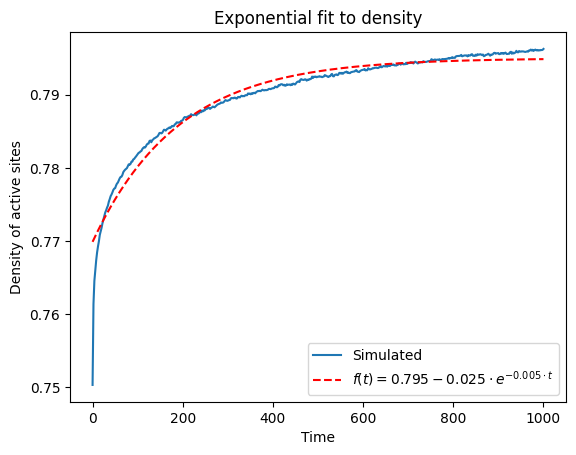

In [ ]:
def fit_and_plot_regular_exp(times, densities):
    def regular_exp(t, A, B, lam):
        return A - B * np.exp(-lam * t)

    # Initial parameter guess: A, B, lambda
    p0 = [max(densities), 0.5, 0.5]
    popt, _ = curve_fit(regular_exp, times, densities, p0=p0, maxfev=5000)

    A_fit, B_fit, lam_fit = popt
    print(f"Fitted parameters:\nA = {A_fit:.6f}, B = {B_fit:.6f}, λ = {lam_fit:.6f}")

    # Explicit function form
    print("\nFitted function:")
    print(f"f(t) = {A_fit:.6f} - {B_fit:.6f} * exp(-{lam_fit:.6f} * t)")

    # Generate fit curve
    fit_curve = regular_exp(np.array(times), *popt)

    # Plot
    plt.plot(times, densities, label='Simulated')
    plt.plot(times, fit_curve, 'r--', label=fr'$f(t) = {A_fit:.3f} - {B_fit:.3f} \cdot e^{{-{lam_fit:.3f} \cdot t}}$')
    plt.xlabel('Time')
    plt.ylabel('Density of active sites')
    plt.title('Exponential fit to density')
    plt.legend()
    plt.show()

# Example usage:
fit_and_plot_regular_exp(times, densities)


## 3.2 Exponential function-stretched

Fitted parameters:
A = 0.803804, B = 0.053444, λ = 0.186896, β = 0.339276

Fitted function:
f(t) = 0.803804 - 0.053444 * exp(-0.186896 * t^0.339276)


/tmp/ipython-input-4254011619.py:3: RuntimeWarning: divide by zero encountered in power
  return A - B * np.exp(- lam * t** beta)


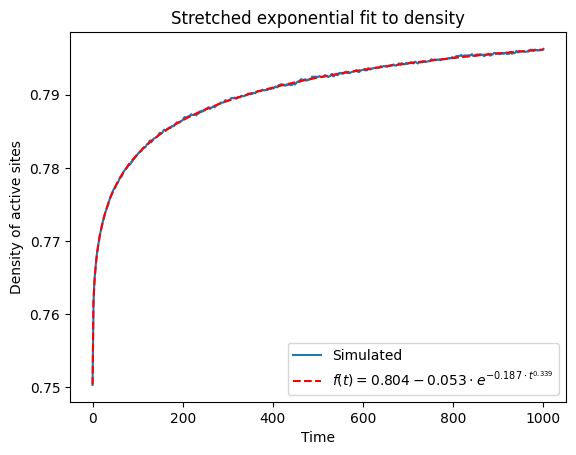

In [ ]:

def fit_and_plot_stretched_exp(times, densities):
    def stretched_exp(t, A, B, lam, beta):
        return A - B * np.exp(- lam * t** beta)

    # Initial parameter guess: A, B, lambda, beta
    p0 = [max(densities), 0.5, 0.5, 0.5]
    popt, _ = curve_fit(stretched_exp, times, densities, p0=p0, maxfev=5000)

    A_fit, B_fit, lam_fit, beta_fit = popt
    print(f"Fitted parameters:\nA = {A_fit:.6f}, B = {B_fit:.6f}, λ = {lam_fit:.6f}, β = {beta_fit:.6f}")

    # Explicit function form
    print("\nFitted function:")
    print(f"f(t) = {A_fit:.6f} - {B_fit:.6f} * exp(-{lam_fit:.6f} * t^{beta_fit:.6f})")

    # Generate fit curve
    fit_curve = stretched_exp(np.array(times), *popt)

    # Plot
    plt.plot(times, densities, label='Simulated')
    plt.plot(times, fit_curve, 'r--', label=fr'$f(t) = {A_fit:.3f} - {B_fit:.3f} \cdot e^{{-{lam_fit:.3f} \cdot t^{{{beta_fit:.3f}}}}}$')
    plt.xlabel('Time')
    plt.ylabel('Density of active sites')
    plt.title('Stretched exponential fit to density')
    plt.legend()
    plt.show()

# Example usage:
fit_and_plot_stretched_exp(times, densities)


## 3.3 Case $\alpha$ = 0

Try to plot this function:

$$\log(1 - q - \mathrm{density(t)})$$
since if the following equation is true:
$$
f(t) = A \left[1 - \exp\left(-(\lambda t)^{\beta}\right)\right]
$$
we have:
$$\log(1 - q - \mathrm{density(t)}) = -(\lambda t)^{\beta}$$

Fitted linear model: y = -0.0004 * t + -3.3623


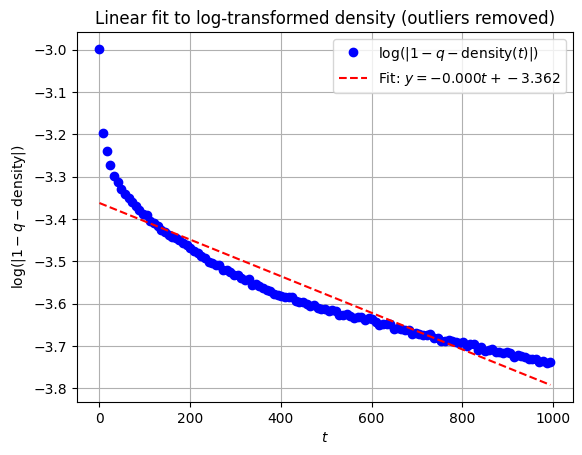

In [ ]:
def plot_and_fit_log_density(times, densities, q):
    # Compute transformed values
    transformed = np.abs(1 - q - np.array(densities))

    # Avoid log of zero or negative values
    mask = transformed > 0
    t_trans = np.array(times)[mask]
    mask_trim = t_trans < 1000
    t_trans = t_trans[mask_trim]
    y_log = np.log(transformed[mask])
    y_log = y_log[mask_trim]

    # --------- Outlier removal: keep only points above a threshold ---------
    threshold = -20  # Change as needed!
    outlier_mask = y_log > threshold
    t_trans_no_out = t_trans[outlier_mask]
    y_log_no_out = y_log[outlier_mask]

    # Define linear function for fitting
    def linear_func(t, a, b):
        return a * t + b

    # Fit the curve (without outliers)
    popt, _ = curve_fit(linear_func, t_trans_no_out, y_log_no_out)
    a_fit, b_fit = popt
    print(f"Fitted linear model: y = {a_fit:.4f} * t + {b_fit:.4f}")

    # Plot
    plt.plot(t_trans_no_out, y_log_no_out, 'bo', label=r'$\log(|1 - q - \mathrm{density}(t)|)$')
    plt.plot(t_trans_no_out, linear_func(t_trans_no_out, *popt), 'r--', label=fr'Fit: $y = {a_fit:.3f}t + {b_fit:.3f}$')
    plt.xlabel(r'$t$')
    plt.ylabel(r'$\log(|1 - q - \mathrm{density}|)$')
    plt.title('Linear fit to log-transformed density (outliers removed)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_and_fit_log_density(times, densities, q=0.1)

## 3.4 Case $\alpha = 1$

Fitted linear model: y = -0.0017 * t + -2.3817


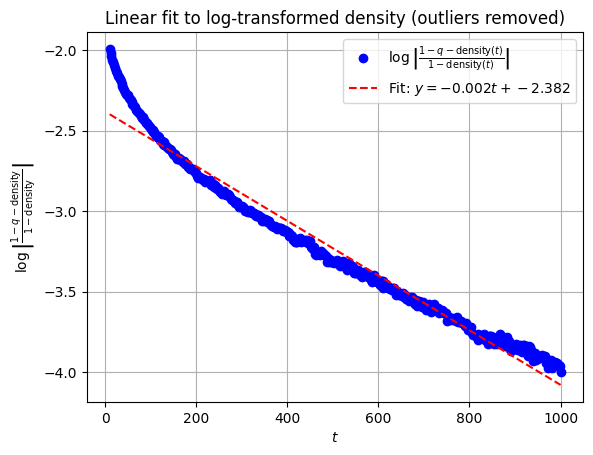

In [ ]:
def plot_and_fit_log_density(times, densities, q):
    # Compute transformed values
    transformed = np.abs((1 - q - np.array(densities)) / (1 - np.array(densities)))

    # Avoid log of zero or negative values
    mask = transformed > 0
    t_trans = np.array(times)[mask]
    y_log = np.log(transformed[mask])

    # Limit time range
    mask_trim = t_trans > 10
    t_trans = t_trans[mask_trim]
    y_log = y_log[mask_trim]

    # --------- Outlier removal: keep only points above a threshold ---------
    threshold = -20  # ← Threshold defined here, inside the function
    outlier_mask = y_log > threshold
    t_trans_no_out = t_trans[outlier_mask]
    y_log_no_out = y_log[outlier_mask]

    # Define linear function for fitting
    def linear_func(t, a, b):
        return a * t + b

    # Fit the curve (without outliers)
    popt, _ = curve_fit(linear_func, t_trans_no_out, y_log_no_out)
    a_fit, b_fit = popt
    print(f"Fitted linear model: y = {a_fit:.4f} * t + {b_fit:.4f}")

    # Plot
    plt.plot(t_trans_no_out, y_log_no_out, 'bo', label=r'$\log\left|\frac{1 - q - \mathrm{density}(t)}{1 - \mathrm{density}(t)}\right|$')
    plt.plot(t_trans_no_out, linear_func(t_trans_no_out, *popt), 'r--', label=fr'Fit: $y = {a_fit:.3f}t + {b_fit:.3f}$')
    plt.xlabel(r'$t$')
    plt.ylabel(r'$\log\left|\frac{1 - q - \mathrm{density}}{1 - \mathrm{density}}\right|$')
    plt.title('Linear fit to log-transformed density (outliers removed)')
    plt.legend()
    plt.grid(True)
    plt.show()


# Example call
plot_and_fit_log_density(times, densities, q=0.2)

## 3.5 Case $\alpha = 2$

Fitted linear model: y ≈ -0.0016 * t + -1.4656


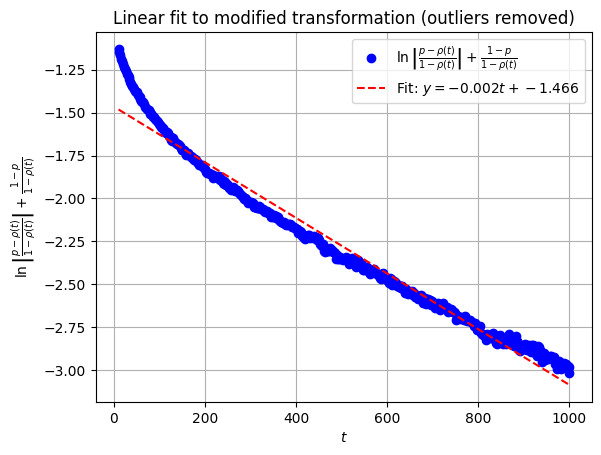

In [ ]:
def plot_and_fit_modified(times, densities, p):
    # Convert to numpy arrays
    times = np.array(times)
    densities = np.array(densities)

    # Compute the transformed y(t) according to your equation
    numerator = np.abs(p - densities)
    denominator = 1 - densities
    transformed = np.log(numerator / denominator) + (1 - p) / denominator

    # Remove any invalid values (log of 0 or negative denominators)
    mask = (numerator > 0) & (denominator > 0)
    t_valid = times[mask]
    y_valid = transformed[mask]

    # Optionally trim time range if needed
    mask_trim = t_valid > 10
    t_valid = t_valid[mask_trim]
    y_valid = y_valid[mask_trim]

    # Outlier removal (example: keep only points above a threshold)
    threshold = -20
    outlier_mask = y_valid > threshold
    t_no_out = t_valid[outlier_mask]
    y_no_out = y_valid[outlier_mask]

    # Define linear function for fitting
    def linear_func(t, C1, C2):
        return C1 * t + C2

    # Fit the line
    popt, _ = curve_fit(linear_func, t_no_out, y_no_out)
    C1_fit, C2_fit = popt
    print(f"Fitted linear model: y ≈ {C1_fit:.4f} * t + {C2_fit:.4f}")

    # Plot
    plt.plot(t_no_out, y_no_out, 'bo',
             label=rf'$\ln\left|\frac{{p-\rho(t)}}{{1-\rho(t)}}\right|+\frac{{1-p}}{{1-\rho(t)}}$')
    plt.plot(t_no_out, linear_func(t_no_out, *popt), 'r--',
             label=fr'Fit: $y = {C1_fit:.3f} t + {C2_fit:.3f}$')
    plt.xlabel(r'$t$')
    plt.ylabel(r'$\ln\left|\frac{p-\rho(t)}{1-\rho(t)}\right|+\frac{1-p}{1-\rho(t)}$')
    plt.title('Linear fit to modified transformation (outliers removed)')
    plt.legend()
    plt.grid(True)
    plt.show()


# Example call:
plot_and_fit_modified(times, densities, p=0.8)

## 3.6 Case $\alpha$ = 3

Fitted linear model: y = 0.0058 * t + 50.7731


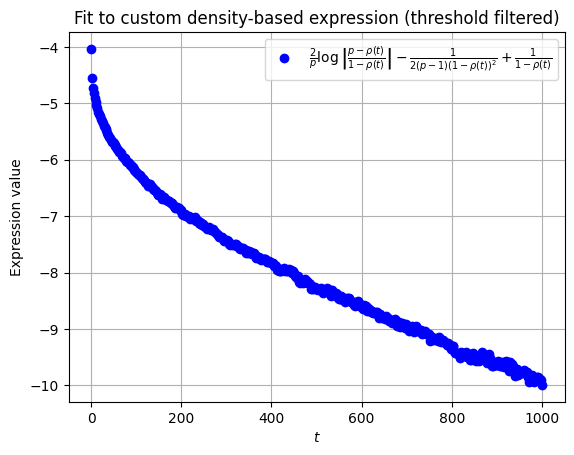

In [ ]:
def plot_custom_expression(times, densities, q):
    p = 1 - q
    rho_t = np.array(densities)
    t_vals = np.array(times)

    # Ensure no division by zero or log of zero/negative
    safe_mask = (1 - rho_t) != 0
    safe_mask &= np.abs((p - rho_t) / (1 - rho_t)) > 0  # Ensure the log input is positive

    rho_t = rho_t[safe_mask]
    t_vals = t_vals[safe_mask]

    # Compute the expression
    term1 = (2 / p) * np.log(np.abs((p - rho_t) / (1 - rho_t)))
    term2 = 1 / (2 * (p - 1) * (1 - rho_t)**2)
    term3 = 1 / (1 - rho_t)
    y_vals = term1 - term2 + term3

    # # Limit time range
    # mask_trim = t_vals < 1000
    # t_vals = t_vals[mask_trim]
    # y_vals = y_vals[mask_trim]

    # Define linear fitting function
    def linear_func(t, a, b):
        return a * t + b

    # Fit (without outliers)
    popt, _ = curve_fit(linear_func, t_vals, y_vals)
    a_fit, b_fit = popt
    print(f"Fitted linear model: y = {a_fit:.4f} * t + {b_fit:.4f}")

    # Plot
    plt.plot(t_vals, term1, 'bo',
         label=r'$\frac{2}{p} \log\left|\frac{p - \rho(t)}{1 - \rho(t)}\right| - \frac{1}{2(p - 1)(1 - \rho(t))^2} + \frac{1}{1 - \rho(t)}$')
    # plt.plot(t_vals, linear_func(t_vals, *popt), 'r--', label=fr'Fit: $y = {a_fit:.3f}t + {b_fit:.3f}$')
    plt.xlabel(r'$t$')
    plt.ylabel(r'Expression value')
    plt.title('Fit to custom density-based expression (threshold filtered)')
    plt.legend()
    plt.grid(True)
    plt.show()
# Example call:
plot_custom_expression(times, densities, q=0.2)

#### Differnce

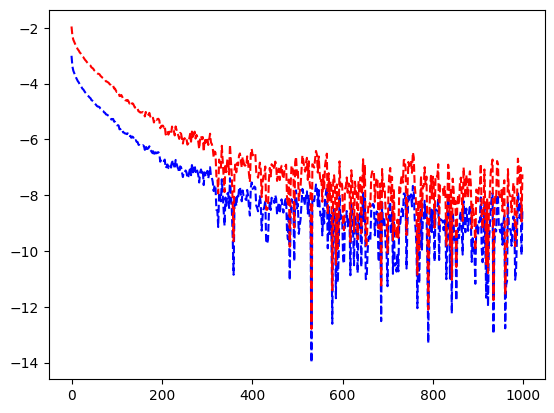

In [ ]:
p = 0.7

# Compute transformed values
transformed = np.abs((p - np.array(densities)))

# Avoid log of zero or negative values
mask = transformed > 0
t_trans = np.array(times)[mask]
mask_trim = t_trans < 1000
t_trans = t_trans[mask_trim]
y_log = np.log(transformed[mask])
y_log_1 = y_log[mask_trim]

transformed = np.abs((p - np.array(densities))/(1-np.array(densities)))

    # Avoid log of zero or negative values
mask = transformed > 0
t_trans = np.array(times)[mask]
mask_trim = t_trans < 1000
t_trans = t_trans[mask_trim]
y_log = np.log(transformed[mask])
y_log_2 = y_log[mask_trim]

plt.plot(t_trans, y_log_1, 'b--', label=r'function 1')
plt.plot(t_trans, y_log_2, 'r--', label=r'$\log\left|\frac{1 - q - \mathrm{density}(t)}{1 - \mathrm{density}(t)}\right|$')

## 3.7 Case FA-1f model $(1- p^2)$

Fitted linear model: y = 0.0042 * t + 13.7824


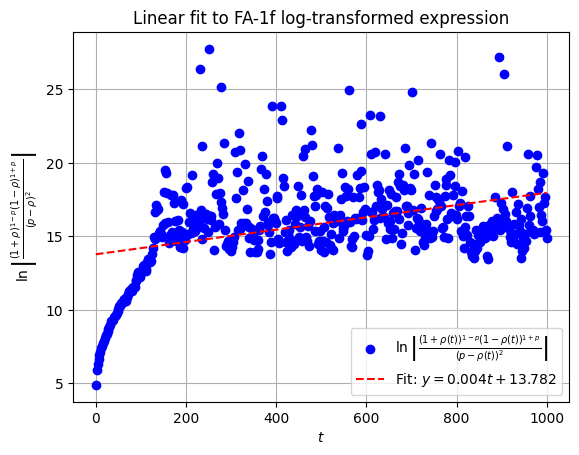

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def plot_fa1f_log_expression(times, densities, p=0.5):
    times = np.array(times)
    densities = np.array(densities)

    # Compute numerator and denominator
    num = (1 + densities)**(1 - p) * (1 - densities)**(1 + p)
    denom = (p - densities)**2

    # Compute the full expression, then filter out invalid values
    expr = num / denom

    # Now build a mask for valid (real, positive, finite) values
    mask = (expr > 0) & np.isfinite(expr)
    t_masked = times[mask]
    expr_masked = expr[mask]
    y_log = np.log(expr_masked)

    # Also remove any remaining NaNs/infs
    valid = np.isfinite(y_log)
    t_final = t_masked[valid]
    y_final = y_log[valid]

    # Optional: remove outliers
    threshold = 40
    outlier_mask = y_final < threshold
    t_final = t_final[outlier_mask]
    y_final = y_final[outlier_mask]

    # Linear fit (only if enough points remain)
    if len(t_final) < 2:
        print("Not enough valid data to fit!")
        return

    def linear_func(t, a, b):
        return a * t + b

    popt, _ = curve_fit(linear_func, t_final, y_final)
    a_fit, b_fit = popt
    print(f"Fitted linear model: y = {a_fit:.4f} * t + {b_fit:.4f}")

    plt.plot(t_final, y_final, 'bo', label=r'$\ln\left| \frac{(1 + \rho(t))^{1-p}(1-\rho(t))^{1+p}}{(p-\rho(t))^2} \right|$')
    plt.plot(t_final, linear_func(t_final, *popt), 'r--', label=fr'Fit: $y = {a_fit:.3f}t + {b_fit:.3f}$')
    plt.xlabel(r'$t$')
    plt.ylabel(r'$\ln\left| \frac{(1 + \rho)^{1-p}(1-\rho)^{1+p}}{(p-\rho)^2} \right|$')
    plt.title('Linear fit to FA-1f log-transformed expression')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example call:
plot_fa1f_log_expression(times, densities, p=0.6)


# 4. Curve fitting with full initial density

In [22]:
# Linear + smooth transition to plateau
def piecewise_smooth(t, y0, m, t1, y_final, tau):
    t = np.array(t)
    linear = y0 + m * t
    smooth = y_final + (linear - y_final) * np.exp(-(t - t1)/tau)
    return np.where(t < t1, linear, smooth)

## 4.1 Plot of the small value of p(starting with 1 as initial density)

Fitted parameters:
y0 = 1.009, m = -0.001409, t1 = 586.6, y_final = 0.100, tau = 35.8
The curve reaches the constant region at t ≈ 643.3


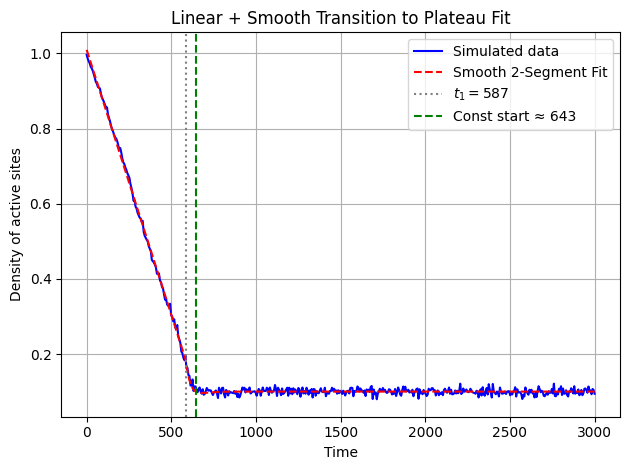

In [25]:

def fit_and_plot_smooth(times, densities):
    # Initial guesses
    y0_guess = densities[0]
    y_final_guess = densities[-1]
    t1_guess = times[len(times)//2]
    m_guess = (densities[-1] - densities[0]) / (times[-1] - times[0])
    tau_guess = (times[-1] - times[0]) / 10  # rough guess for smoothness

    p0 = [y0_guess, m_guess, t1_guess, y_final_guess, tau_guess]

    # Fit with curve_fit
    popt, _ = curve_fit(piecewise_smooth, times, densities, p0=p0, maxfev=20000)
    y0_fit, m_fit, t1_fit, y_final_fit, tau_fit = popt

    print(f"Fitted parameters:")
    print(f"y0 = {y0_fit:.3f}, m = {m_fit:.6f}, t1 = {t1_fit:.1f}, "
          f"y_final = {y_final_fit:.3f}, tau = {tau_fit:.1f}")

    # Generate fitted curve
    fit_curve = piecewise_smooth(times, *popt)

    # Find the point where the curve reaches ~99% of the final plateau
    # i.e., |value - y_final| <= 1% of (y0 - y_final)
    threshold = abs(y0_fit - y_final_fit) * 0.001
    idx_const = np.argmax(np.abs(fit_curve - y_final_fit) <= threshold)
    t_const = times[idx_const] if idx_const > 0 else None

    if t_const:
        print(f"The curve reaches the constant region at t ≈ {t_const:.1f}")

    # Plot
    plt.plot(times, densities, 'b-', label='Simulated data')
    plt.plot(times, fit_curve, 'r--', label='Smooth 2-Segment Fit')
    plt.axvline(t1_fit, color='gray', linestyle=':', label=f'$t_1={t1_fit:.0f}$')
    if t_const:
        plt.axvline(t_const, color='green', linestyle='--', label=f'Const start ≈ {t_const:.0f}')
    plt.xlabel('Time')
    plt.ylabel('Density of active sites')
    plt.title('Linear + Smooth Transition to Plateau Fit')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return popt, t_const

# Example usage:
popt, t_const = fit_and_plot_smooth(times, densities)


## 4.2 Fitting for different values of L(fixed p)

In [27]:
def estimate_gradient(times, densities):
    """Fit piecewise_smooth and return the fitted parameters (esp. m)."""
    y0_guess = densities[0]
    y_final_guess = densities[-1]
    t1_guess = times[len(times)//2]
    m_guess = (densities[-1] - densities[0]) / (times[-1] - times[0])
    tau_guess = (times[-1] - times[0]) / 10

    p0 = [y0_guess, m_guess, t1_guess, y_final_guess, tau_guess]
    popt, pcov = curve_fit(piecewise_smooth, times, densities, p0=p0, maxfev=20000)
    y0_fit, m_fit, t1_fit, y_final_fit, tau_fit = popt
    return {
        "y0": y0_fit, "m": m_fit, "t1": t1_fit, "y_final": y_final_fit, "tau": tau_fit,
        "cov": pcov
    }


In [28]:
def sweep_L_for_m(
    simulation_fn,
    L_values,
    *,
    p=0.7,
    t_max=100.0,
    N_points=500,
    num_runs=100,
    base_seed=42,
    initial=0
):
    """
    For each L in L_values:
      - run ave_simulation (already parallelized internally)
      - fit piecewise_smooth
      - record m (and other fit params)
    Returns a tidy DataFrame.
    """
    rows = []
    for L in tqdm(L_values, desc="Sweeping L", position=0):
        seed = None if base_seed is None else base_seed + (hash(("L", L, "p", p)) % 10**6)
        times, dens = ave_simulation(
            simulation_fn=simulation_fn,
            L=L, p=p, t_max=t_max, seed=seed,
            num_runs=num_runs, N_points=N_points, initial=initial
        )
        fit = estimate_gradient(times, dens)
        v = -L * fit['m']/(1-p)
        rows.append({
            "L": L,
            "p": p,
            "m": fit["m"],
            "v": v,
            "y0": fit["y0"],
            "t1": fit["t1"],
            "y_final": fit["y_final"],
            "tau": fit["tau"]
        })
    return pd.DataFrame(rows).sort_values("L").reset_index(drop=True)


In [29]:
def plot_v_vs_L(df):
    plt.figure()
    sub = df.sort_values("L")
    plt.plot(sub["L"], sub["v"], marker="o")
    plt.xlabel("L")
    plt.ylabel("velocity v (from fit)")
    plt.title("Velocity v vs L")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Simulating:  33%|███▎      | 1/3 [00:04<00:09,  4.52s/it]
                                                         /tmp/ipython-input-532265325.py:5: RuntimeWarning: overflow encountered in exp
  smooth = y_final + (linear - y_final) * np.exp(-(t - t1)/tau)
/tmp/ipython-input-1338672843.py:10: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(piecewise_smooth, times, densities, p0=p0, maxfev=20000)
Sweeping L: 100%|██████████| 5/5 [01:14<00:00, 14.96s/it]

      L    p         m         v        y0           t1   y_final  \
0   100  0.1 -0.006967  0.774062  0.965657   121.064754  0.099903   
1   500  0.1 -0.001385  0.769331  0.990216   587.154282  0.099970   
2  1000  0.1 -0.000719  0.799264  0.987936  1232.466513  0.100181   
3  2000  0.1 -0.000366  0.812255  1.000137  2294.651090  0.112738   
4  3000  0.1 -0.000243  0.809389  0.994489  2867.736596 -1.819835   

            tau  
0      0.026062  
1     34.135736  
2      0.287301  
3    215.819477  
4  89469.220874  


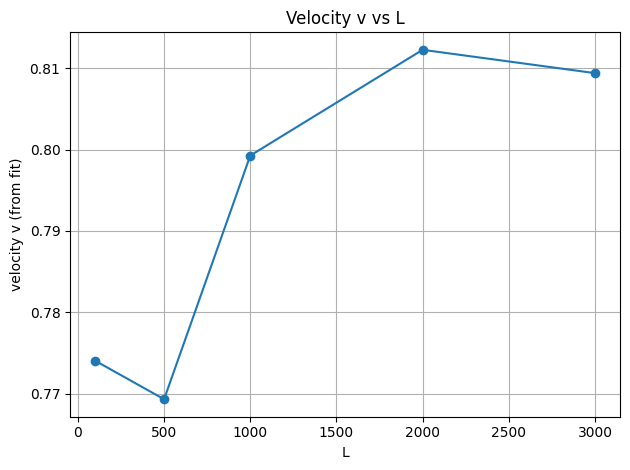

In [31]:
# Choose sizes (geometric spacing is useful)
L_values = [100, 500, 1000, 2000, 3000]

# Fixed p for this experiment
p_fixed = 0.1

# Run the sweep (uses your existing simulation & averaging)
df_L = sweep_L_for_m(
    simulation_fn=simulation_fa1f_full,
    L_values=L_values,
    p=p_fixed,
    t_max=3000.0,
    N_points=500,
    num_runs=3,   # adjust for runtime
    base_seed=42,
)

print(df_L)

# Plots
plot_v_vs_L(df_L)


## 4.3 Fitting for different values of p (fixed L)

In [32]:
def estimate_gradient(times, densities):
    """Fit piecewise_smooth and return the fitted parameters (esp. m)."""
    y0_guess = densities[0]
    y_final_guess = densities[-1]
    t1_guess = times[len(times)//2]
    m_guess = (densities[-1] - densities[0]) / (times[-1] - times[0])
    tau_guess = (times[-1] - times[0]) / 10

    p0 = [y0_guess, m_guess, t1_guess, y_final_guess, tau_guess]
    popt, pcov = curve_fit(piecewise_smooth, times, densities, p0=p0, maxfev=20000)
    y0_fit, m_fit, t1_fit, y_final_fit, tau_fit = popt
    return {
        "y0": y0_fit, "m": m_fit, "t1": t1_fit, "y_final": y_final_fit, "tau": tau_fit,
        "cov": pcov
    }


In [33]:
def sweep_p_for_m(
    simulation_fn,
    p_values,
    *,
    L=1000,
    t_max=100.0,
    N_points=500,
    num_runs=100,
    base_seed=42,
    initial=0
):
    """
    For each p in p_values:
      - run ave_simulation (already parallelized internally)
      - fit piecewise_smooth
      - record m and v = -L*m/(1-p)
    Returns a tidy DataFrame sorted by p.
    """
    rows = []
    for p in tqdm(p_values, desc="Sweeping p", position=0):
        if np.isclose(p, 1.0):
            raise ValueError("p=1 leads to division by zero in v = -L*m/(1-p).")
        seed = None if base_seed is None else base_seed + (hash(("L", L, "p", p)) % 10**6)

        times, dens = ave_simulation(
            simulation_fn=simulation_fn,
            L=L, p=p, t_max=t_max, seed=seed,
            num_runs=num_runs, N_points=N_points, initial=initial
        )
        fit = estimate_gradient(times, dens)
        v = -L * fit["m"] / (1.0 - p)

        rows.append({
            "L": L,
            "p": p,
            "m": fit["m"],
            "v": v,
            "y0": fit["y0"],
            "t1": fit["t1"],
            "y_final": fit["y_final"],
            "tau": fit["tau"]
        })
    return pd.DataFrame(rows).sort_values("p").reset_index(drop=True)


In [34]:
def plot_v_vs_p(df):
    sub = df.sort_values("p")
    plt.figure()
    plt.plot(sub["p"], sub["v"], marker="o")
    plt.xlabel("p")
    plt.ylabel("velocity v = -L*m/(1-p)")
    plt.title(f"v vs p (L={int(sub['L'].iloc[0])})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Sweeping p: 100%|██████████| 5/5 [01:17<00:00, 15.48s/it]


      L     p             m         v        y0           t1   y_final  \
0  5000  0.02 -1.840639e-04  0.939102  0.999645   912.359756 -0.833935   
1  5000  0.50 -2.044787e-05  0.204479  0.999772  1406.813854  0.886594   
2  5000  0.60 -7.761723e-06  0.097022  0.999444   745.510571  0.646956   
3  5000  0.70 -3.035243e-06  0.050587  0.999452  1584.427556  0.987782   
4  5000  0.90 -2.646631e-07  0.013233  0.999683  1593.279279  0.999736   

             tau  
0  182989.844993  
1   32303.015182  
2   84214.876931  
3    2805.154020  
4    1368.024918  


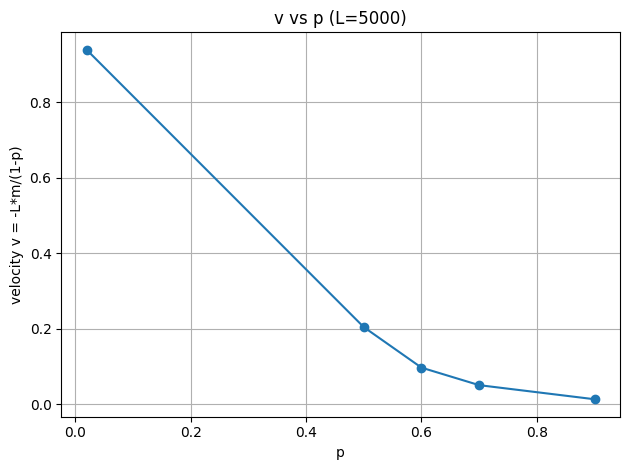

In [39]:
# Fix L for this experiment
L_fixed = 5000

p_values = np.array([0.02, 0.5, 0.6, 0.7, 0.9])

# Run the sweep
df_p = sweep_p_for_m(
    simulation_fn=simulation_fa1f_full,
    p_values=p_values,
    L=L_fixed,
    t_max=3000.0,
    N_points=500,
    num_runs=3,      # adjust as needed
    base_seed=42,
)

print(df_p)

# Plot
plot_v_vs_p(df_p)
